# Aula 36 - Redes Complexas

### Instalação das bibliotecas

In [1]:
#!pip install git+https://github.com/networkx/networkx.git

### Importação das bibliotecas

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx

### Análise simples de grafos

#### Funções para plotar a distribuição

In [3]:
def plot_degree_dist(G):
    degrees= [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.title('Grau dos nós', size=12, y=1.05)
    plt.show()
    

def plot_compsize_dist(G):
    sizes= [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
    plt.hist(sizes)
    plt.title('Componentes conectados', size=12, y=1.05)
    plt.show()
    

def plot_cumulative_compsize_dist(G):
    sizes =[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
    cumulative = np.cumsum(sizes)
    plt.plot(cumulative)
    plt.title('Soma acumulada dos componentes conectados', size=12, y=1.05)
    plt.show()
    

def plot_diameter_dist(G):
    diameters= [nx.diameter(G.subgraph(c)) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
    plt.hist(diameters)
    plt.title('Diâmetro do grafo', size=12, y=1.05)
    plt.show()


def plot_cliquesize_dist(G):
    sizes =[len(c) for c in sorted(nx.find_cliques(G), key=len, reverse=True) if len(c)>2]
    plt.hist(sizes)
    plt.title('Cliques do grafo', size=12, y=1.05)
    plt.show()

#### Carregando o grafo

In [4]:
G = nx.karate_club_graph()

In [5]:
print(f'Número de vértices: {len(G)}')
print(f'Número de arestas: {G.number_of_edges()}')
print(f'Coeficiente de agrupamento: {nx.average_clustering(G)}')
print(f'Número de triângulos {sum(nx.triangles(G).values())}')
print(f'Número de componentes: {len(list(nx.connected_components(G)))}')

Número de vértices: 34
Número de arestas: 78
Coeficiente de agrupamento: 0.5706384782076823
Número de triângulos 135
Número de componentes: 1


#### Plotando as distribuições

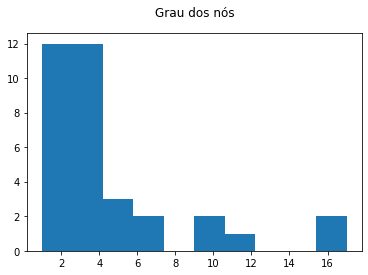

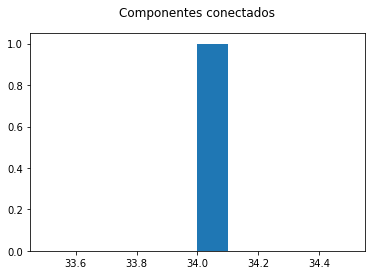

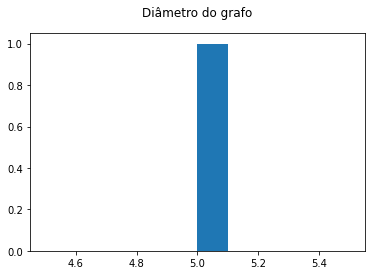

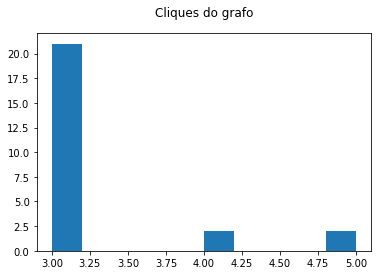

In [6]:
plot_degree_dist(G)
plot_compsize_dist(G)
plot_diameter_dist(G)
plot_cliquesize_dist(G)

#### Maior componente

In [7]:
maxCompSet= max(nx.connected_components(G), key=len)
print(f'Maiores componentes: {maxCompSet}\n')
maxCompG= G.subgraph(maxCompSet)

print(f'Número de vértices: {len(maxCompG)}')
print(f'Número de arestas: {maxCompG.number_of_edges()}')
print(f'Coeficiente de agrupamento: {nx.average_clustering(maxCompG)}')
print(f'Número de triângulos: {sum(nx.triangles(maxCompG).values())}')
print(f'Distância média entre nós: {nx.average_shortest_path_length(maxCompG)}')

Maiores componentes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}

Número de vértices: 34
Número de arestas: 78
Coeficiente de agrupamento: 0.5706384782076823
Número de triângulos: 135
Distância média entre nós: 2.408199643493761


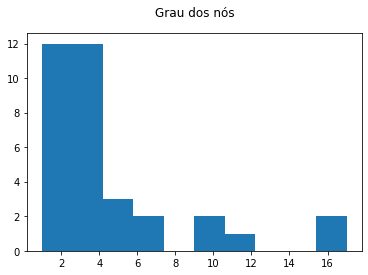

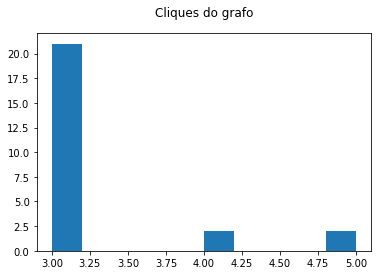

In [8]:
plot_degree_dist(maxCompG)
plot_cliquesize_dist(maxCompG)

#### Desenhando o grafo

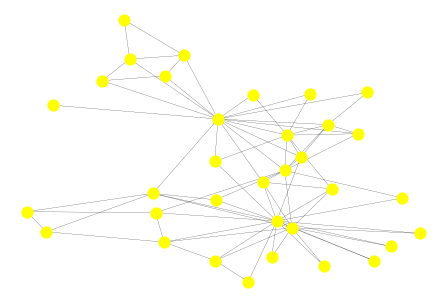

In [9]:
options = {
    'node_color': 'yellow',
    'node_size': 150,
    'line_color': 'black',
    'linewidths': 0.,
    'width': 0.2,
}

cores = nx.core_number(maxCompG)
vals = np.fromiter(cores.values(), dtype=int)
nx.draw_spring(maxCompG, **options)

### Detecção de comunidades

In [10]:
import networkx.algorithms.community as nxcom

#### Percolação de cliques (clique percolation)

In [11]:
cs= nxcom.k_clique_communities(G, 3)
cs= tuple(sorted(c) for c in cs)
print(cs)

([0, 1, 2, 3, 7, 8, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31, 32, 33], [0, 4, 5, 6, 10, 16], [24, 25, 31])


In [12]:
map_partition= {}
i=0

for c in cs:
    for n in c:
        map_partition[n]= i
    i=i+1
    
    
for n in G.nodes():
    if n not in map_partition.keys():
        map_partition[n]=i
        cs = cs + ([n],)
        i=i+1
        
print(cs)

([0, 1, 2, 3, 7, 8, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31, 32, 33], [0, 4, 5, 6, 10, 16], [24, 25, 31], [9], [11])


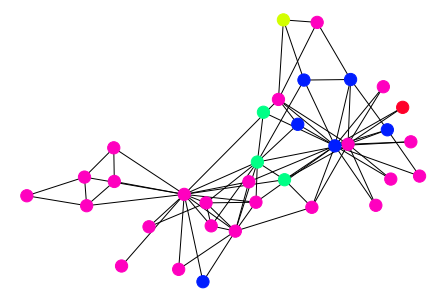

In [13]:
cols = [map_partition[key] for key in sorted(map_partition.keys(), reverse=True)]
nx.draw_spring(maxCompG, cmap= plt.cm.gist_rainbow_r, node_color= cols, node_size=150)

#### Desenhando melhor as comunidades

In [14]:
def community_layout(g, partition):
    """
    Calcule o layout para um gráfico modular.


    Arguments:
    ----------
    g -- networkx. Graph or networkx. Intância do grafo para plot.

    partition -- dict mapping int. Nós do grafo.


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y). Posições dos nós.

    """

    pos_communities = _position_communities(g, partition, scale=3.)
    pos_nodes = _position_nodes(g, partition, scale=1.)


    pos = {}
    
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos



def _position_communities(g, partition, **kwargs):
    
    """
        Cria um gráfico ponderado, no qual cada nó corresponde a uma comunidade 
        e cada peso de borda ao número de bordas entre comunidades.
        Encontra layout para comunidades.
        Define posições do nó para a posição da comunidade
    
    """


    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))


    pos_communities = nx.spring_layout(hypergraph, **kwargs)
    pos = {}
    
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos



def _find_between_community_edges(g, partition):

    edges = {}

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges



def _position_nodes(g, partition, **kwargs):
    """
        Posiciona nós nas comunidades.
    """

    communities = {}
    
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]


    pos = {}
    
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

In [15]:
import collections

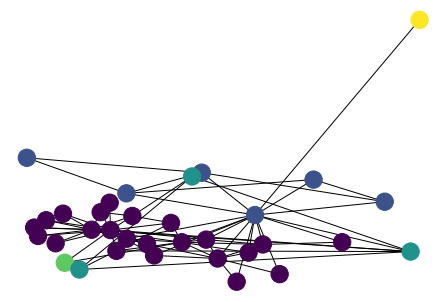

In [16]:
od = collections.OrderedDict(sorted(map_partition.items()))
pos = community_layout(G, od)
nx.draw(G, pos, node_color=list(od.values()))

In [17]:
cs = nxcom.girvan_newman(G)
cs = tuple(sorted(c) for c in next(cs))
print(cs)

([0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21], [2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])


Performance: 0.6114081996434938
Cobertura: 0.8717948717948718


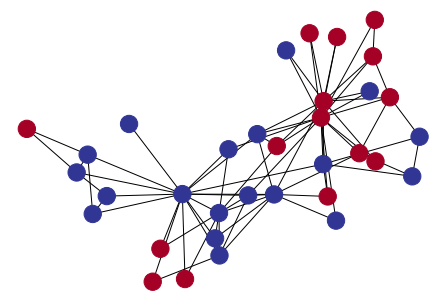

In [18]:
map_partition={}
i=0


for c in cs:
    for n in c:
        map_partition[n]=i
    i=i+1

    
for n in G.nodes():
    if n not in map_partition.keys():
        map_partition[n]=-1


cols = [map_partition[key] for key in sorted(map_partition.keys(), reverse=True)]
nx.draw_spring(maxCompG, cmap =  plt.cm.RdYlBu, node_color=cols)

print(f'Performance: {nxcom.performance(G,cs)}')
print(f'Cobertura: {nxcom.coverage(G,cs)}')

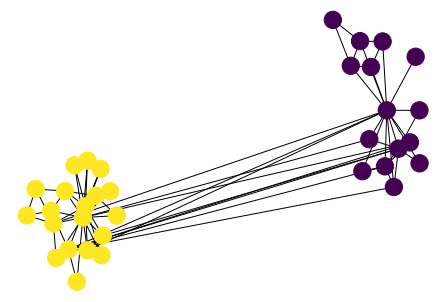

In [19]:
od = collections.OrderedDict(sorted(map_partition.items()))
pos = community_layout(G, od)

nx.draw(G, pos, node_color=list(od.values()))

#### Label propagation

In [20]:
cs = nxcom.label_propagation_communities(G)
cs = tuple(sorted(c) for c in cs)

Performance: 0.6684491978609626
Cobertura: 0.7692307692307693


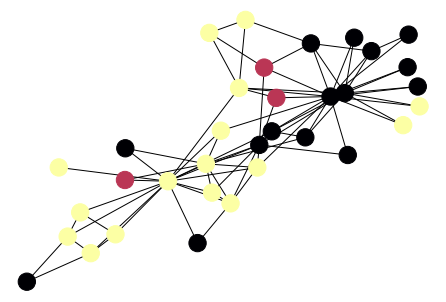

In [21]:
map_partition={}
i=0


for c in cs:
    for n in c:
        map_partition[n]=i
    i=i+1

    
for n in G.nodes():
    if n not in map_partition.keys():
        map_partition[n]=-1
        

cols = [map_partition[key] for key in sorted(map_partition.keys(), reverse=True)]
nx.draw_spring(maxCompG, cmap =  plt.cm.inferno_r, node_color=cols)

print(f'Performance: {nxcom.performance(G,cs)}')
print(f'Cobertura: {nxcom.coverage(G,cs)}')

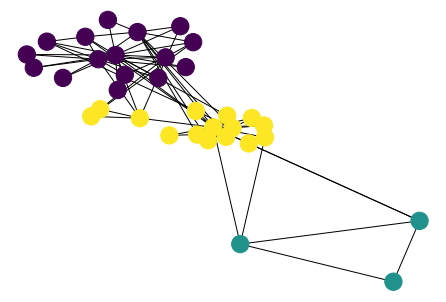

In [22]:
od = collections.OrderedDict(sorted(map_partition.items()))
pos = community_layout(G, od)

nx.draw(G, pos, node_color=list(od.values()))

### PageRank

In [23]:
pr= nx.pagerank(G, alpha=0.9)

In [24]:
for k, v in sorted(pr.items(), key=lambda item: item[1], reverse=True):
    print(f'Node: {k} | Pr: {v}')

Node: 33 | Pr: 0.10345460652842152
Node: 0 | Pr: 0.09923208031303203
Node: 32 | Pr: 0.07330616298815512
Node: 2 | Pr: 0.05919704684187155
Node: 1 | Pr: 0.0543403155825792
Node: 31 | Pr: 0.037572665335286734
Node: 3 | Pr: 0.036612460562853694
Node: 23 | Pr: 0.03165330491466868
Node: 8 | Pr: 0.030411546757834793
Node: 13 | Pr: 0.030254309009995452
Node: 5 | Pr: 0.028358863602879276
Node: 6 | Pr: 0.028358863602879276
Node: 29 | Pr: 0.02603805549234405
Node: 27 | Pr: 0.025579985022944167
Node: 30 | Pr: 0.024824588072166538
Node: 7 | Pr: 0.024777139411941047
Node: 4 | Pr: 0.02129205163493875
Node: 10 | Pr: 0.02129205163493875
Node: 24 | Pr: 0.02045532726885293
Node: 25 | Pr: 0.020410702877569672
Node: 19 | Pr: 0.019434610880594574
Node: 28 | Pr: 0.01938173195115044
Node: 16 | Pr: 0.015703158296594022
Node: 26 | Pr: 0.014276670024478019
Node: 12 | Pr: 0.014015169158033743
Node: 17 | Pr: 0.01395744128254017
Node: 21 | Pr: 0.01395744128254017
Node: 14 | Pr: 0.013916466828162465
Node: 15 | Pr: 

In [25]:
import matplotlib.colors as mcolors

In [26]:
def draw(G, pos, measures, measure_name):
    
    nodes = nx.draw_networkx_nodes(G, 
                                   pos, 
                                   node_size=250, 
                                   cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=list(measures.keys())
                                  )
    
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
    
    edges = nx.draw_networkx_edges(G, pos)

    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

In [27]:
c = nx.degree_centrality(G)
print(c)

{0: 0.48484848484848486, 1: 0.2727272727272727, 2: 0.30303030303030304, 3: 0.18181818181818182, 4: 0.09090909090909091, 5: 0.12121212121212122, 6: 0.12121212121212122, 7: 0.12121212121212122, 8: 0.15151515151515152, 9: 0.06060606060606061, 10: 0.09090909090909091, 11: 0.030303030303030304, 12: 0.06060606060606061, 13: 0.15151515151515152, 14: 0.06060606060606061, 15: 0.06060606060606061, 16: 0.06060606060606061, 17: 0.06060606060606061, 18: 0.06060606060606061, 19: 0.09090909090909091, 20: 0.06060606060606061, 21: 0.06060606060606061, 22: 0.06060606060606061, 23: 0.15151515151515152, 24: 0.09090909090909091, 25: 0.09090909090909091, 26: 0.06060606060606061, 27: 0.12121212121212122, 28: 0.09090909090909091, 29: 0.12121212121212122, 30: 0.12121212121212122, 31: 0.18181818181818182, 32: 0.36363636363636365, 33: 0.5151515151515151}


/home/liliane-hop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  # This is added back by InteractiveShellApp.init_path()


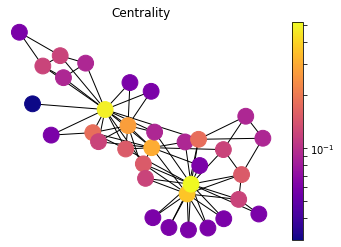

In [28]:
pos = nx.spring_layout(G)
draw(G, pos, c, 'Centrality')